# Comparison 3D

Comparison of algorithms provided in `localthickness` module with other algorithms. In particular, we compare with the results of [BoneJ](https://bonej.org/) plugin for ImageJ, which is considered golden standard, especially for computation of trabecular thickness and trabecular spacing of bone samples. The results of BoneJ have been pre-computed and saved. BoneJ computes both thickness and separation (which is the thickness of the *other* region of the binary image) we also look at both regions in the notebook.

We include conventional algorithm which uses dilation with discs of increasing radius. It is very slow so the results have been pre-computed, and only for thicnkess, as the separation took too long to run. This can serve as groundt truth. Finally, we also compare with the results of the algorithm from the [porespy](https://porespy.org/) package, [local_thickness](https://porespy.org/modules/generated/generated/porespy.filters.local_thickness.html).

This notebook can only be **wieved** to check how our algorithms compare with other algorithms, in terms of run time and the quality of output. If you want to **run** the notebook, you need to run BoneJ off-line, and save the results. Also you need to run and save the conventional algorithm, implemented in `lt.local_thickness_conventional`. To use `porespy` you need to install it and possibly fix a problem with `ipywidgets` as described in 2D notebook. 

In [1]:
import matplotlib.pyplot as plt
import localthickness as lt
import porespy as ps
import time
import numpy as np
import tifffile

In [2]:
# Load test volume.
filename = 'data/random_test_volume.tif'
B = tifffile.imread(filename)>0

th, sp, times_th, times_sp = {}, {}, {}, {}

In [3]:
# Conventional algorithm, a ground truth.
# Loading results pre-computed results as it takes to long time to process.
# Furthermore, I can only process thickness, spacing takes too long.
# If you want to produce results yourself, uncomment and run next cell.
th['Conventional'] = np.load('../GT_output/th_gt.npy')
times_th['Conventional'] = np.load('../GT_output/time_th_gt.npy')

In [4]:
# BoneJ -- considered a golden standard.
# Loading results computed and saved using BoneJ plugin in Fiji.
# BoneJ uses NaN for other material, while other algorithms use 0.
# Also, BoneJ uses diameter, not radius, therefore division with 2.
th['BoneJ'] = np.nan_to_num(tifffile.imread('../BoneJ_output/random_test_volume_Tb_Th.tif')/2)
sp['BoneJ'] = np.nan_to_num(tifffile.imread('../BoneJ_output/random_test_volume_Tb_sp.tif')/2)

# I estimated that boneJ took 2 + 4 seconds to compute thickness and spacing.
times_th['BoneJ'] = 2.
times_sp['BoneJ'] = 4.


In [5]:
# start_time = time.time()
# th_gt = lt.local_thickness_conventional(B, verbose=True)
# time_th_gt = time.time() - start_time
# np.save('../GT_output/th_gt.npy', th_gt)
# np.save('../GT_output/time_th_gt.npy', time_th_gt)

In [6]:
methods = {
    'Fast': lt.local_thickness,
    'Scaled 0.5': lambda B: lt.local_thickness(B, scale=0.5),
    'PoreSpy': ps.filters.local_thickness
    }

In [7]:
for methodname in methods.keys():
    print(f'Processing using {methodname} method. ')
    start_time = time.time()
    th[methodname] = methods[methodname](B)
    times_th[methodname] = time.time() - start_time
    start_time = time.time()
    sp[methodname] = methods[methodname](~B)
    times_sp[methodname] = time.time() - start_time
    

Processing using Fast method. 
Processing using Scaled 0.5 method. 
Processing using PoreSpy method. 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

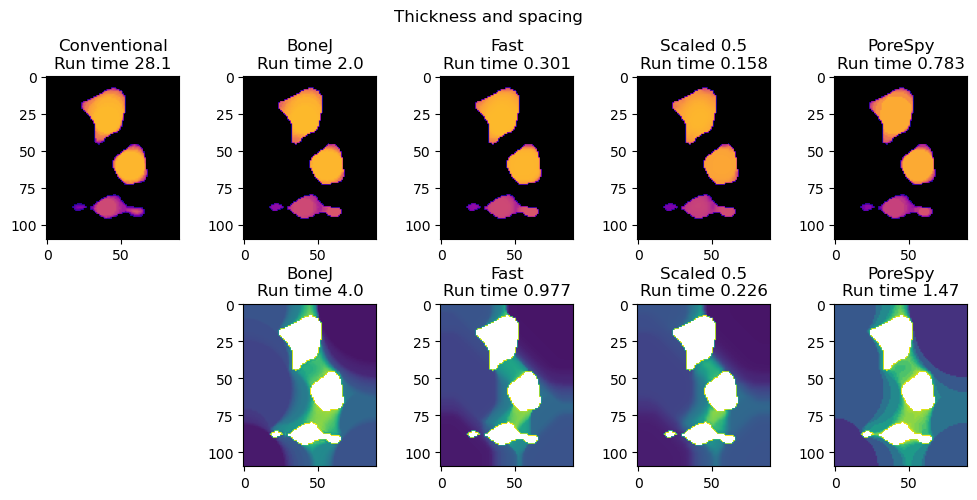

In [8]:
# Visualize.
z = 80  # slice to show
th_maxval = th['BoneJ'].max()
sp_maxval = sp['BoneJ'].max()

fig, ax = plt.subplots(2, len(th), figsize=(10, 5))

for ath, asp, methodname in zip(ax[0], ax[1], th.keys()):
    ath.imshow(th[methodname][z], vmin=0, vmax=th_maxval, cmap=lt.black_plasma())
    ath.set_title(f'{methodname}\nRun time {times_th[methodname]:.03}')
    if methodname != 'Conventional':
        asp.imshow(sp[methodname][z], vmin=0, vmax=sp_maxval, cmap=lt.white_viridis())
        asp.set_title(f'{methodname}\nRun time {times_sp[methodname]:.03}')
    else:
        asp.remove()

fig.suptitle('Thickness and spacing')
plt.tight_layout()
plt.show()

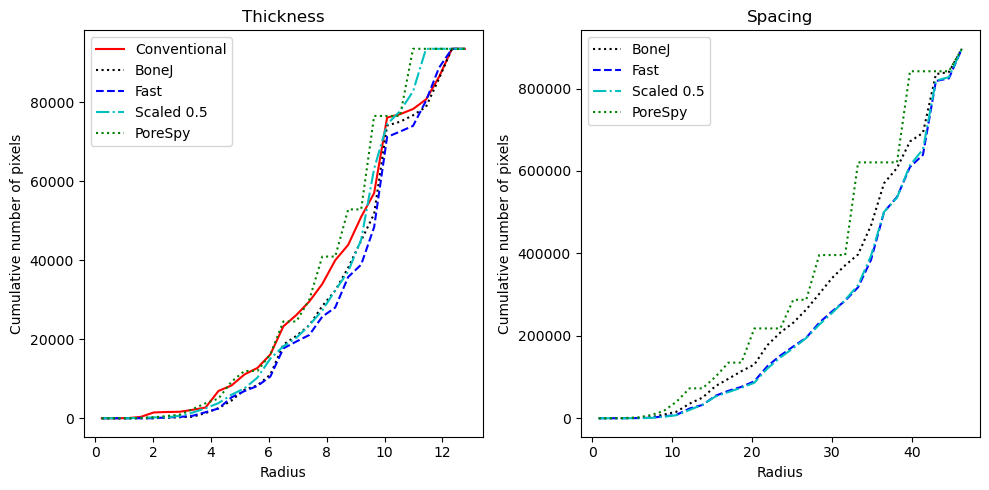

In [12]:
b_th = np.linspace(0, np.ceil(th_maxval), 30)
b_sp = np.linspace(0, np.ceil(sp_maxval), 30)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for methodname, line in zip(th.keys(), ['r', 'k:', 'b--', 'c-.', 'g:']):
    cs_th = np.cumsum(np.histogram(th[methodname][B], bins=b_th)[0])
    ax[0].plot(0.5*(b_th[1:]+b_th[:-1]), cs_th, line, label=methodname)
    if methodname != 'Conventional':
        cs_sp = np.cumsum(np.histogram(sp[methodname][~B], bins=b_sp)[0])
        ax[1].plot(0.5*(b_sp[1:]+b_sp[:-1]), cs_sp, line, label=methodname)

for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel('Radius')
    ax[i].set_ylabel('Cumulative number of pixels')
ax[0].set_title('Thickness')
ax[1].set_title('Spacing')

plt.tight_layout()
plt.show()


###### Conclusion
The algorithm from BoneJ is a suitable golden standard, as the results are similar to the conventional approach, which is the closest to ground truth. Otherwise the results resemble the results obtained for 2D. Our results are also close to ground truth, and generally overestimate. Results of porespy are discrete and underestimate.

In terms of run time, our algorithm without scaling is comparable to porespy. With scaling is much faster.